In [1]:
import matplotlib.pyplot as plt
import itertools
import time
import numpy as np
from tqdm import tqdm
import json
import pandas as pd

In [2]:
label_list = [
    r"$f(z_{\mathrm{qnt}},\theta^*)$(95%)",
    r"$f(z_{\mathrm{qnt}},\theta^*)$(90%)",
    r"$f(z_{\mathrm{qnt}},\theta^*)$(85%)",
    r"$f(z_{\mathrm{qnt}},\theta^*)$(80%)",
    r"$f(z_{\mathrm{boot}},\theta^*)$(99%)",
    r"$f(z_{\mathrm{boot}},\theta^*)$(95%)",
    r"$f(z_{\mathrm{boot}},\theta^*)$(90%)",
    r"$f(z_{\mathrm{opt}},\theta^*)(z^{\mathrm{range}}=1.5)$",
    r"$f(z_{\mathrm{opt}},\theta^*)(z^{\mathrm{range}}=2.0)$",
    r"$f(z_{\mathrm{opt}},\theta^*)(z^{\mathrm{range}}=2.5)$",
    r"$f(z_{\mathrm{opt}},\theta^*)(z^{\mathrm{range}}=3.0)$",
]

In [3]:
path = "results.json"

with open(path, "r") as f:
    results = json.load(f)


In [4]:
results['M5_delta0.6'].keys()

dict_keys(['so', 'po', 'quan95', 'quan90', 'quan85', 'quan80', 'boot99', 'boot95', 'boot90', 'ebpa3', 'ebpa4', 'ebpa5', 'ebpa6', 'r2_list'])

In [5]:
# 仮に m5_data が M5_delta0.6 の辞書だとする
m5_data = results['M5_delta0.6']

filtered = {}
for method_name, metrics in m5_data.items():
    # method_name が 'quan' か 'boot' か 'ebpa' で始まるかを判定
    if method_name.startswith('quan') or method_name.startswith('boot') or method_name.startswith('ebpa'):
        filtered[method_name] = metrics['range_diff']

# 結果確認
for k, v in filtered.items():
    print(k, len(v), '件')


quan95 100 件
quan90 100 件
quan85 100 件
quan80 100 件
boot99 100 件
boot95 100 件
boot90 100 件
ebpa3 100 件
ebpa4 100 件
ebpa5 100 件
ebpa6 100 件


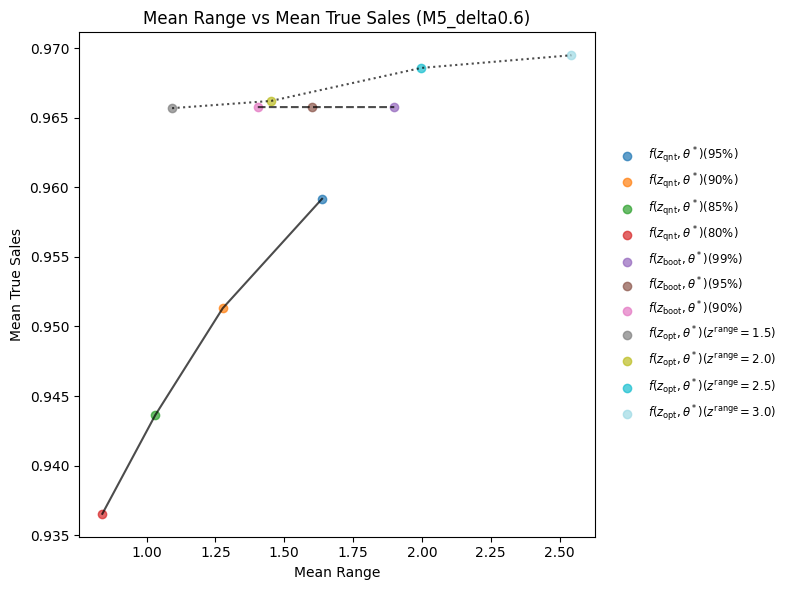

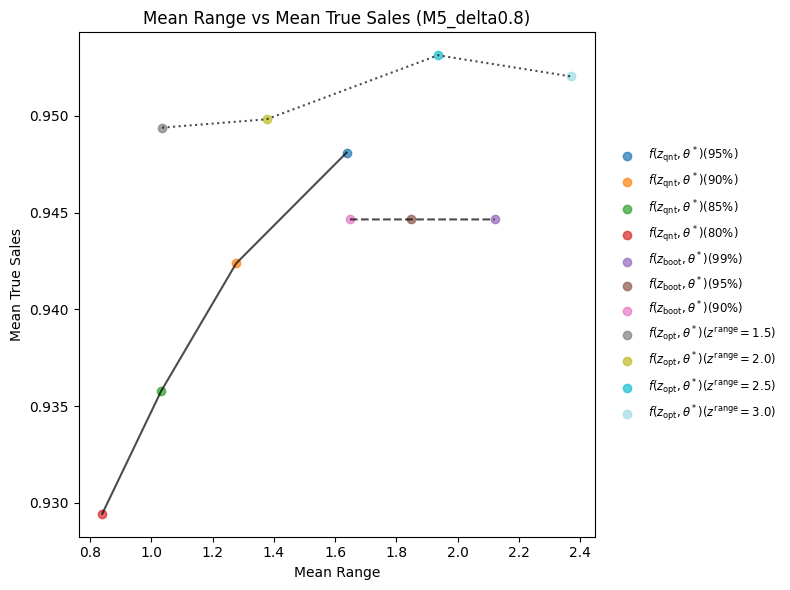

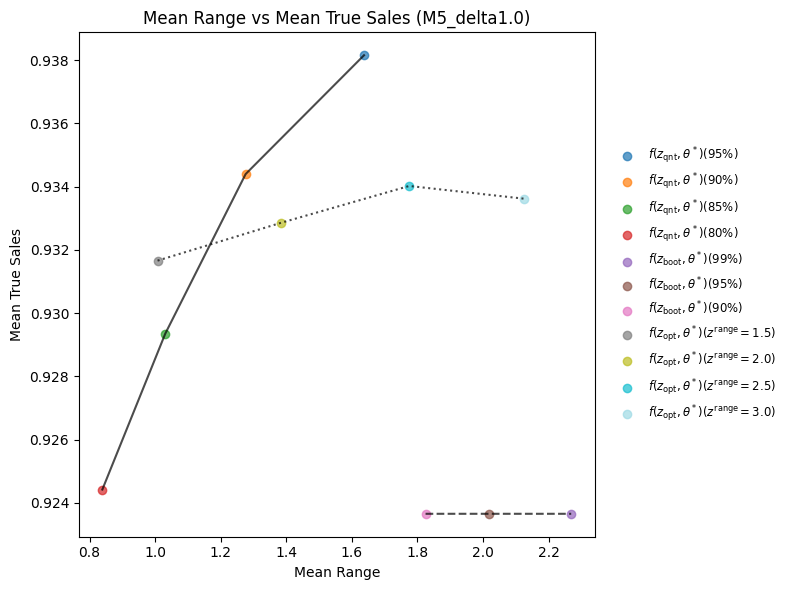

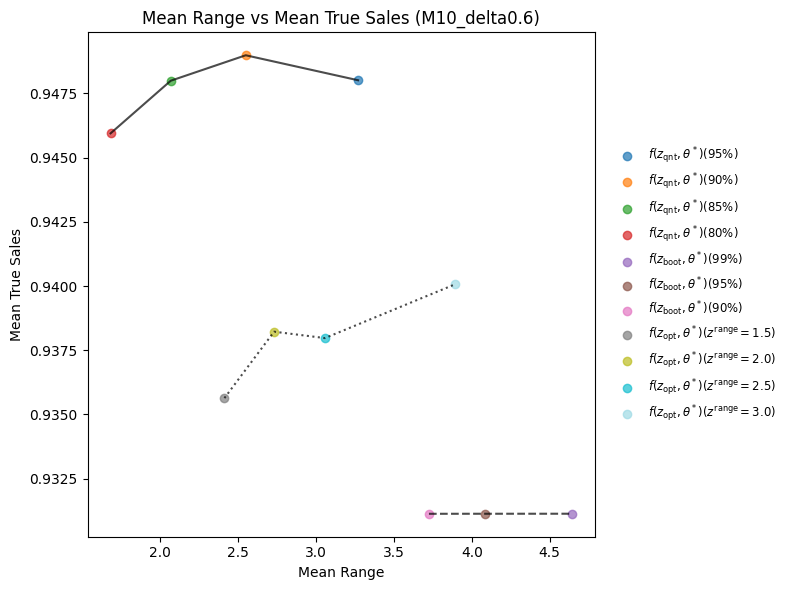

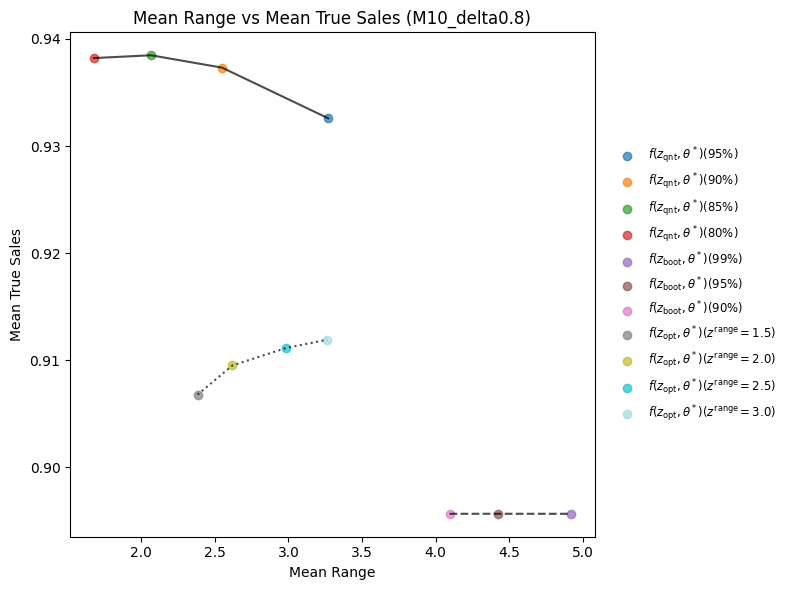

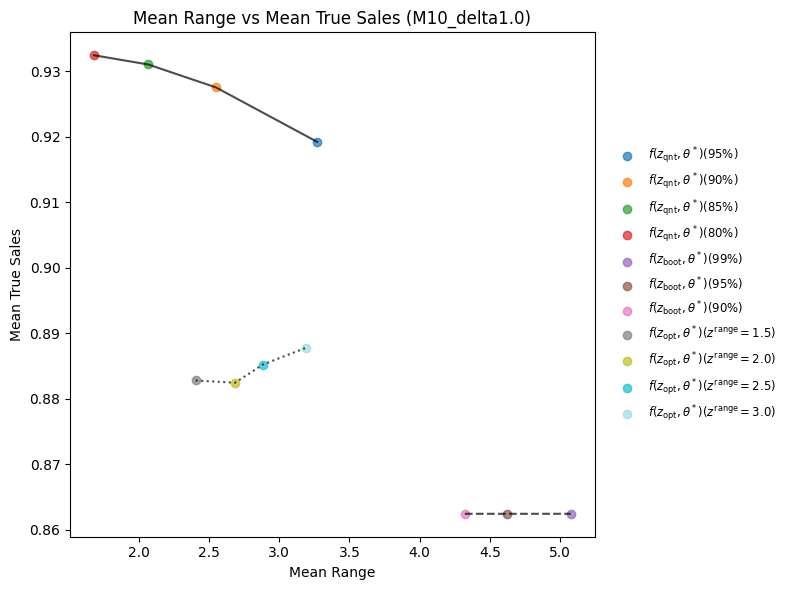

In [8]:


def create_fig_from_json(path, label_list=label_list):
    # jsonファイルの読み込み
    with open(path, "r") as f:
        results = json.load(f)
    
    # 全てのKEYに対して処理を行う
    for key, data in results.items():
        # プロット用リスト
        range_vals = []
        true_sales_vals = []

        # 各メソッドの結果をフィルタリング
        for method_name, metrics in data.items():
            if method_name.startswith(('quan', 'boot', 'ebpa')):
                range_vals.append(np.mean(metrics['range_diff']))
                true_sales_vals.append(np.mean(metrics['true_sales_ratio']))
        
        # --- ここから大事 ---
        fig, ax = plt.subplots(figsize=(8, 6))
        cmap = plt.get_cmap('tab20', len(range_vals))

        # 散布図
        for i, (r, ts, lbl) in enumerate(zip(range_vals, true_sales_vals, label_list)):
            ax.scatter(r, ts, label=lbl, color=cmap(i), alpha=0.7)
        
        # インデックス指定
        idx_qnt  = list(range(0, 4))
        idx_boot = list(range(4, 7))
        idx_opt  = list(range(7, 11))

        # plot_group をここで定義 — 同じスコープの ax, range_vals, true_sales_vals を使える！
        def plot_group(idxs, linestyle):
            if len(idxs) < 2:
                return
            xs = [range_vals[i] for i in idxs]
            ys = [true_sales_vals[i] for i in idxs]
            xs_s, ys_s = zip(*sorted(zip(xs, ys), key=lambda t: t[0]))
            ax.plot(xs_s, ys_s,
                    linestyle=linestyle,
                    marker=None,
                    color='black',
                    alpha=0.7)

        # 各系列を描画（マーカーなし）
        plot_group(idx_qnt,  '-')
        plot_group(idx_boot, '--')
        plot_group(idx_opt,  ':')

        # 軸・タイトル・凡例
        ax.set_xlabel("Mean Range")
        ax.set_ylabel("Mean True Sales")
        ax.set_title(f"Mean Range vs Mean True Sales ({key})")
        ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5),
                  frameon=False, fontsize='small')

        plt.subplots_adjust(right=0.75)
        plt.tight_layout()
        plt.show()
        # --- ここまで ---

# 実行例
create_fig_from_json(path)


def create_fig_from_json(path, label_list=label_list):
    # JSON読み込み
    with open(path, "r") as f:
        results = json.load(f)
    
    for key, data in results.items():
        # 平均値と標準誤差を格納するリスト
        range_vals      = []
        true_sales_vals = []
        range_se        = []
        sales_se        = []

        # データ抽出
        for method_name, metrics in data.items():
            if method_name.startswith(('quan', 'boot', 'ebpa')):
                arr_r  = np.array(metrics['range_diff'])
                arr_ts = np.array(metrics['true_sales_ratio'])
                # 平均
                range_vals.append(arr_r.mean())
                true_sales_vals.append(arr_ts.mean())
                # 標準誤差 = 標本標準偏差 / √n
                range_se.append(arr_r.std(ddof=1) / np.sqrt(100))
                sales_se.append(arr_ts.std(ddof=1) / np.sqrt(100))

        # 描画準備
        fig, ax = plt.subplots(figsize=(8, 6))
        cmap = plt.get_cmap('tab20', len(range_vals))

        # エラーバー付き散布図
        for i, (r, ts, err_r, err_ts, lbl) in enumerate(
                zip(range_vals, true_sales_vals, range_se, sales_se, label_list)):
            ax.errorbar(
                r, ts,
                xerr=err_r, yerr=err_ts,
                fmt='o',               # マーカーは "o"
                color=cmap(i),         # 点の色
                ecolor=cmap(i),        # エラーバーの色
                capsize=3,             # エラーバー端のキャップ長
                alpha=0.7,
                label=lbl
            )

        # 折れ線をつなぐインデックス
        idx_qnt  = list(range(0, 4))
        idx_boot = list(range(4, 7))
        idx_opt  = list(range(7, 11))

        # 折れ線プロット（マーカーなし）
        def plot_group(idxs, linestyle):
            if len(idxs) < 2:
                return
            xs = [range_vals[i]      for i in idxs]
            ys = [true_sales_vals[i] for i in idxs]
            xs_s, ys_s = zip(*sorted(zip(xs, ys), key=lambda t: t[0]))
            ax.plot(
                xs_s, ys_s,
                linestyle=linestyle,
                marker=None,
                color='black',
                alpha=0.7
            )

        plot_group(idx_qnt,  '-')
        plot_group(idx_boot, '--')
        plot_group(idx_opt,  ':')

        # 軸ラベル・タイトル・凡例
        ax.set_xlabel("Mean Range")
        ax.set_ylabel("Mean True Sales")
        ax.set_title(f"Mean Range vs Mean True Sales ({key})")
        ax.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            frameon=False,
            fontsize='small'
        )

        plt.subplots_adjust(right=0.75)
        plt.tight_layout()
        plt.show()

# 実行例
create_fig_from_json(path)


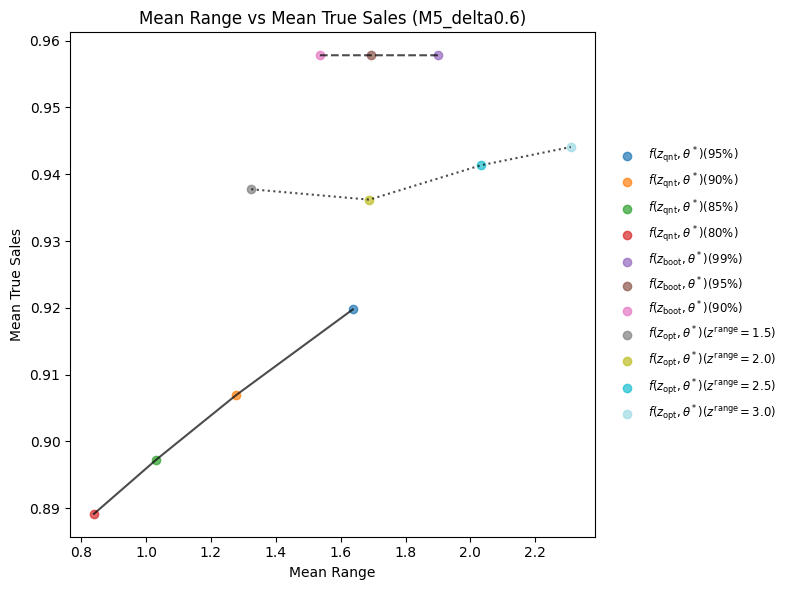

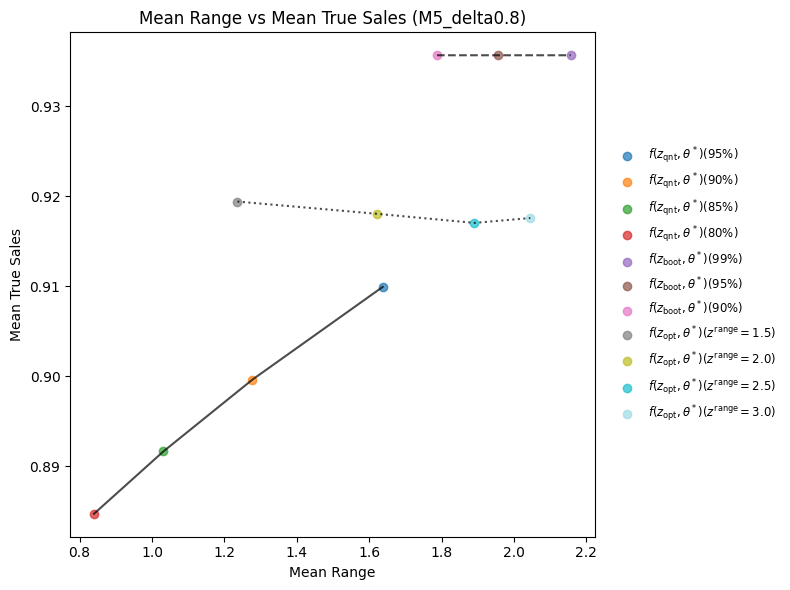

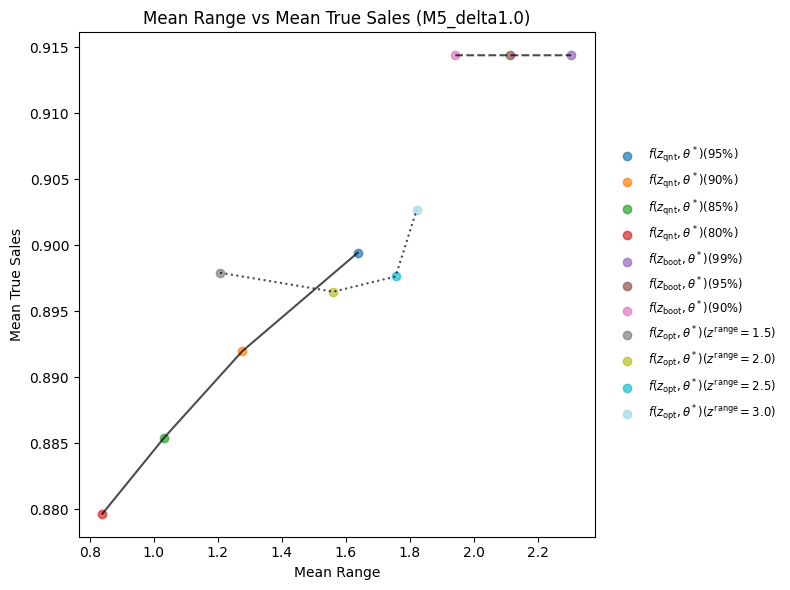

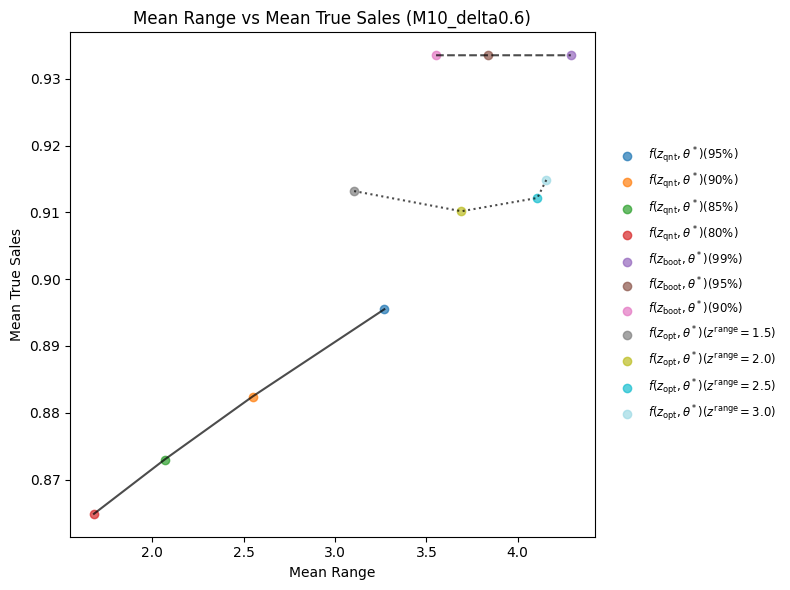

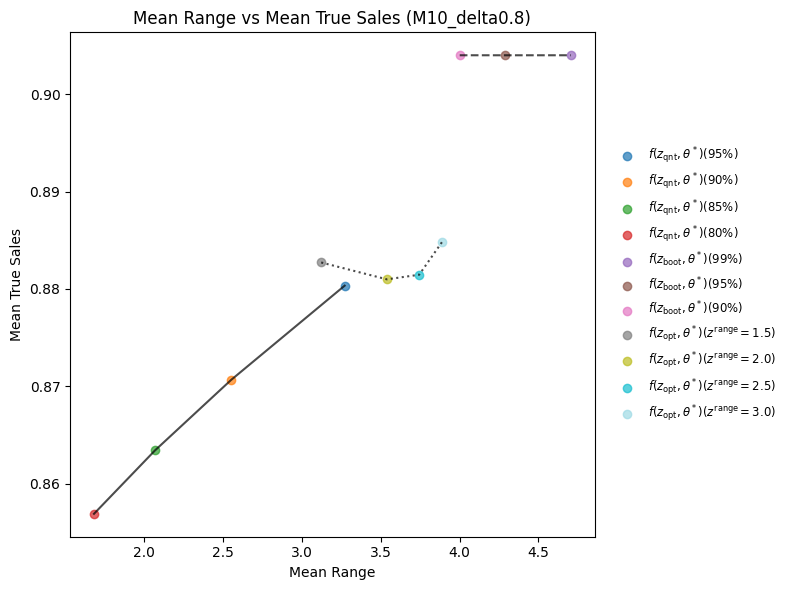

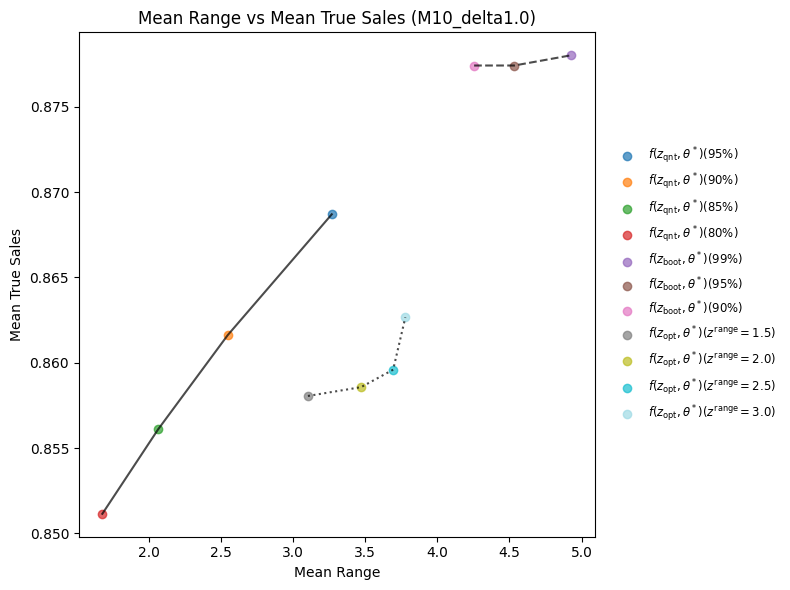

In [9]:
path_ito = "results_praito.json"

create_fig_from_json(path_ito, label_list)